# Stock Market Strategy Backtesting

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### Collecting Nifty 50 data from yfinance library

In [2]:
symbol = '^NSEI'
start_date = datetime.today() - timedelta(days=25)
end_date = datetime.today()
all_data = []

current_start = start_date

while current_start < end_date:
    current_end = min(current_start + timedelta(days=6), end_date)
    data = yf.download(
        symbol,
        interval='1m',
        start=current_start.strftime('%Y-%m-%d'),
        end=(current_end + timedelta(days=1)).strftime('%Y-%m-%d')
    )
    if not data.empty:
        all_data.append(data)
    current_start = current_end + timedelta(days=1)

nifty50_1min = pd.concat(all_data)
nifty50_1min = nifty50_1min.tz_convert('Asia/Kolkata')
nifty50_1min["date"] = nifty50_1min.index.date
nifty50_1min

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,date
Ticker,^NSEI,^NSEI,^NSEI,^NSEI,^NSEI,
Datetime,,,,,,
2025-07-14 09:15:00+05:30,25119.449219,25149.050781,25114.650391,25149.050781,0,2025-07-14
2025-07-14 09:16:00+05:30,25094.500000,25122.599609,25093.849609,25120.250000,0,2025-07-14
2025-07-14 09:17:00+05:30,25099.699219,25102.150391,25087.099609,25093.650391,0,2025-07-14
2025-07-14 09:18:00+05:30,25091.550781,25107.949219,25090.000000,25098.050781,0,2025-07-14
2025-07-14 09:19:00+05:30,25099.300781,25103.599609,25089.500000,25089.500000,0,2025-07-14
...,...,...,...,...,...,...
2025-08-06 15:25:00+05:30,24573.349609,24582.500000,24572.800781,24582.500000,0,2025-08-06
2025-08-06 15:26:00+05:30,24575.300781,24577.000000,24573.300781,24574.150391,0,2025-08-06


### Strategy

In [3]:
entries= []
Target_value = 40
StopLoss_value = 30

for date, group in nifty50_1min.groupby(by='date'):
    if len(group) < 2:
        continue
    ref_candle = group.iloc[0]
    ref_low = ref_candle['Low'].iloc[0]
    for i in range(1, len(group)):
        open_price = group.iloc[i]['Open'].iloc[0]
        if open_price < ref_low:
            entry_time = group.index[i]
            entry_price = open_price
            # Check for target or stop loss in subsequent candles
            for j in range(i+1, len(group)):
                low = group.iloc[j]['Low'].iloc[0]
                high = group.iloc[j]['High'].iloc[0]
                if low <= entry_price - Target_value:
                    result = 'Target'
                    exit_price = entry_price - Target_value
                    exit_time = group.index[j]
                    break
                elif high >= entry_price + StopLoss_value:
                    result = 'StopLoss'
                    exit_price = entry_price + StopLoss_value
                    exit_time = group.index[j]
                    break
            else:
                result = 'NoExit'
                exit_price = group.iloc[-1]['Close']
                exit_time = group.index[-1]
            entries.append({
                'Date': date,
                'EntryTime': entry_time,
                'EntryPrice': entry_price,
                'Result': result,
                'ExitTime': exit_time,
                'ExitPrice': exit_price
            })
            break  # Only one trade per day

# Convert to DataFrame for analysis
trades = pd.DataFrame(entries)
trades

,Date,EntryTime,EntryPrice,Result,ExitTime,ExitPrice
0,2025-07-14,2025-07-14 09:17:00+05:30,25093.650391,Target,2025-07-14 09:24:00+05:30,25053.650391
1,2025-07-16,2025-07-16 09:20:00+05:30,25159.699219,StopLoss,2025-07-16 11:54:00+05:30,25189.699219
2,2025-07-17,2025-07-17 09:21:00+05:30,25202.599609,Target,2025-07-17 10:14:00+05:30,25162.599609
3,2025-07-18,2025-07-18 09:17:00+05:30,25100.699219,Target,2025-07-18 09:42:00+05:30,25060.699219
4,2025-07-21,2025-07-21 09:17:00+05:30,24952.800781,Target,2025-07-21 09:23:00+05:30,24912.800781
5,2025-07-22,2025-07-22 09:21:00+05:30,25122.699219,Target,2025-07-22 10:45:00+05:30,25082.699219
6,2025-07-23,2025-07-23 09:29:00+05:30,25108.250000,StopLoss,2025-07-23 11:03:00+05:30,25138.250000
7,2025-07-24,2025-07-24 09:16:00+05:30,25218.050781,Target,2025-07-24 09:49:00+05:30,25178.050781
8,2025-07-25,2025-07-25 09:17:00+05:30,24938.300781,StopLoss,2025-07-25 09:28:00+05:30,24968.300781
9,2025-07-28,2025-07-28 09:17:00+05:30,24743.449219,StopLoss,2025-07-28 09:19:00+05:30,24773.449219


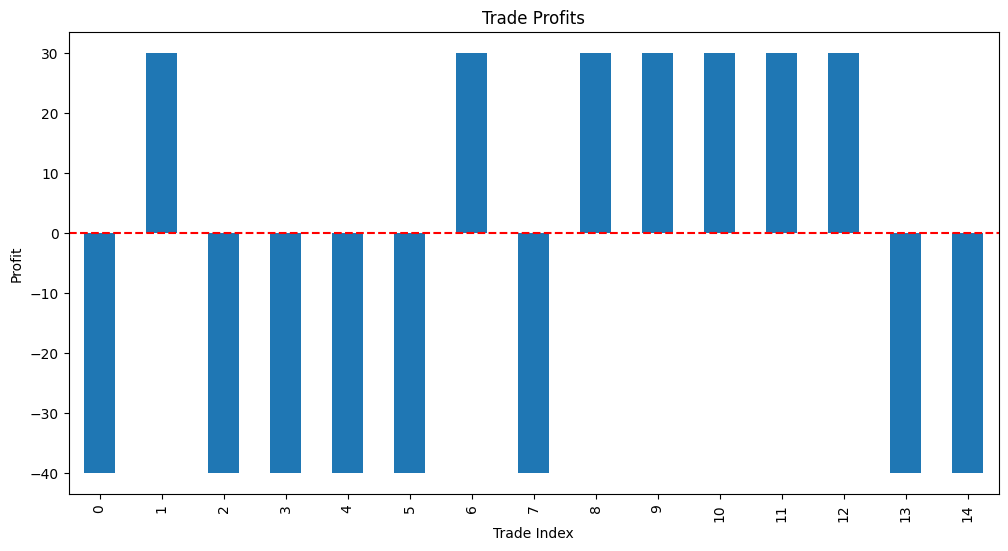

In [4]:
trades['Profit'] = trades['ExitPrice'] - trades['EntryPrice']
trades['Profit'].plot(kind='bar', figsize=(12, 6), title='Trade Profits')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Trade Index')
plt.ylabel('Profit')
plt.show()



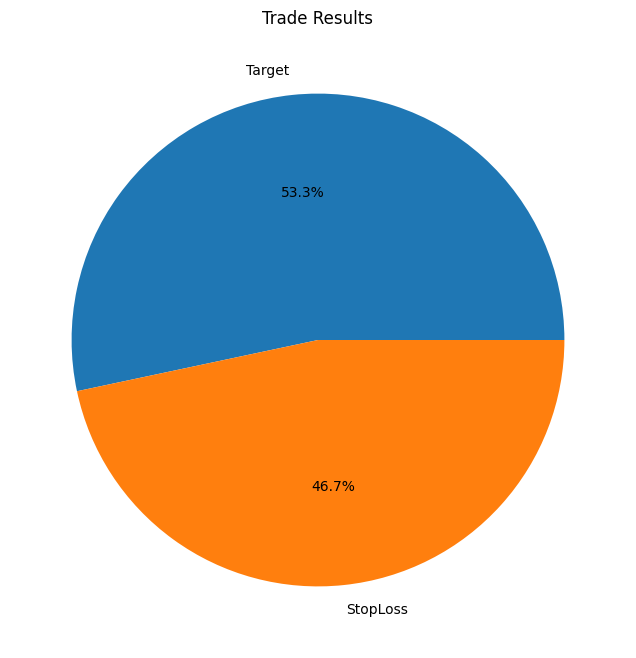

In [5]:
trades['Result'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(8, 8), title='Trade Results')
plt.ylabel('') 
plt.show()

### Backtest the strategy with different **Target** and **StopLoss** values

In [6]:
best_target = None
best_stoploss = None
max_targets = 0

results = []

for target in range(10, 105, 5): 
    
    for stoploss in range(10, 105, 5):
        entries = []
        
        for date, group in nifty50_1min.groupby(by='date'):
            if len(group) < 2:
                continue
            ref_candle = group.iloc[0]
            ref_low = ref_candle['Low'].iloc[0]
            
            for i in range(1, len(group)):
                open_price = group.iloc[i]['Open'].iloc[0]
                if open_price < ref_low:
                    entry_time = group.index[i]
                    entry_price = open_price

                    for j in range(i+1, len(group)):
                        low = group.iloc[j]['Low'].iloc[0]
                        high = group.iloc[j]['High'].iloc[0]
                        if low <= entry_price - target:
                            result = 'Target'
                            exit_price = entry_price - target
                            exit_time = group.index[j]
                            break
                        elif high >= entry_price + stoploss:
                            result = 'StopLoss'
                            exit_price = entry_price + stoploss
                            exit_time = group.index[j]
                            break
                    else:
                        result = 'NoExit'
                        exit_price = group.iloc[-1]['Close']
                        exit_time = group.index[-1]
                    entries.append({
                        'Date': date,
                        'EntryTime': entry_time,
                        'EntryPrice': entry_price,
                        'Result': result,
                        'ExitTime': exit_time,
                        'ExitPrice': exit_price
                    })
                    break
                
        trades_df = pd.DataFrame(entries)
        target_hits = (trades_df['Result'] == 'Target').sum()
        stoploss_hits = (trades_df['Result'] == 'StopLoss').sum()
        
        results.append({
            'Target': target,
            'Stoploss': stoploss,
            'Target_hits': target_hits,
            "stoploss_hits": stoploss_hits,
            "risk_reward_ratio": target / stoploss
        })
        if target_hits > max_targets:
            max_targets = target_hits
            best_target = target
            best_stoploss = stoploss

print(f"The optimal Target: {best_target}, optimal StopLoss: {best_stoploss}, Target Hits: {max_targets}")

results_df = pd.DataFrame(results)


The optimal Target: 10, optimal StopLoss: 40, Target Hits: 13


In [7]:
# results_df.sort_values(by='Target_hits', ascending=False, inplace=True)

In [8]:
results_df

,Target,Stoploss,Target_hits,stoploss_hits,risk_reward_ratio
0,10,10,7,8,1.000000
1,10,15,8,7,0.666667
2,10,20,9,6,0.500000
3,10,25,11,4,0.400000
4,10,30,12,3,0.333333
...,...,...,...,...,...
356,100,80,5,6,1.250000
357,100,85,5,6,1.176471
358,100,90,6,5,1.111111
359,100,95,6,5,1.052632


In [22]:
results_df.columns = [col.lower() for col in results_df.columns]
results_df["risk_reward_ratio"] = results_df["risk_reward_ratio"].round(2)
results_df["success_rate"] = (results_df['target_hits'] / (results_df['target_hits'] + results_df['stoploss_hits'])).round(2)

In [23]:
results_df = results_df.sort_values(by=['target_hits', "risk_reward_ratio"], ascending=[False, False])

In [15]:
results_df

,target,stoploss,target_hits,stoploss_hits,risk_reward_ratio,success_rate
44,20,40,13,2,0.50,0.87
45,20,45,13,2,0.44,0.87
46,20,50,13,2,0.40,0.87
25,15,40,13,2,0.38,0.87
47,20,55,13,2,0.36,0.87
...,...,...,...,...,...,...
325,95,20,3,11,4.75,0.21
306,90,20,3,11,4.50,0.21
345,100,25,3,10,4.00,0.23
326,95,25,3,10,3.80,0.23


In [16]:
results_df.to_csv('stock_strategy_results.csv', index=False)

In [25]:
df = pd.read_csv('stock_strategy_results.csv')

optimal_rows = (
    df.sort_values(['success_rate', 'target_hits', 'risk_reward_ratio'], ascending=[False, False, False])
      .groupby('success_rate', as_index=False)
      .first()
)

result_to_gp = optimal_rows[['success_rate', 'risk_reward_ratio', 'target_hits', 'stoploss_hits', 'target', 'stoploss' ]].sort_values(by="success_rate", ascending=False)

In [26]:
result_to_gp.to_csv("optimal_target_stoploss.csv", index=False)

In [27]:
final_report = pd.read_csv("optimal_target_stoploss.csv")

In [28]:
final_report

,success_rate,risk_reward_ratio,target_hits,stoploss_hits,target,stoploss
0,0.87,0.50,13,2,20,40
1,0.80,0.67,12,3,20,30
2,0.79,0.45,11,3,45,100
3,0.77,0.70,10,3,70,100
4,0.73,0.83,11,4,25,30
5,0.71,0.78,10,4,70,90
6,0.69,0.85,9,4,85,100
7,0.67,1.00,10,5,25,25
8,0.64,0.94,9,5,85,90
9,0.60,1.20,9,6,30,25
